# DrugMechDB BiothingsExplorer TRAPI Analysis

This will be similar to `2_dmdb_mrn_analysis` but using the results we got from BTE Explorer.

This notebook is still under construction.

In [1]:
import pandas as pd
import networkx as nx
from pathlib import Path

import requests
from itertools import chain
from collections import defaultdict

from biothings_client import get_client

import seaborn as sns
import matplotlib.pyplot as plt
from data_tools.plotting import count_plot_h
from data_tools import df_processing as dt

/home/mmayers/sft/miniconda3/lib/python3.8/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
this_name = '4_dmdb_bte_trapi_analysis'
out_dir = Path('../2_pipeline').joinpath(this_name, 'out').resolve()
out_dir.mkdir(exist_ok=True, parents=True)

data_dir = Path('../0_data/external').resolve()

In [3]:
ind = nx.read_yaml(data_dir.joinpath('indication_paths.yaml'))

In [4]:
prev_dir = Path('../2_pipeline/3_querying_bte_trapi/out/').resolve()
bte_result = pd.read_csv(prev_dir.joinpath('BTE_TRAPI_result.csv'))
bte_id_maps = pd.read_csv(prev_dir.joinpath('BTE_id_maps.csv'))

## Drug info

In [5]:
dmdb_drugs = defaultdict(list)
for p in ind:
    for k in ['drug_mesh', 'drugbank', 'drug']:
        dmdb_drugs[k].append(p['graph'][k])
dmdb_drugs = pd.DataFrame(dmdb_drugs)

In [6]:
dmdb_drugs = dmdb_drugs.drop_duplicates().reset_index(drop=True)
dmdb_drugs

,drug_mesh,drugbank,drug
0,MESH:D000068877,DB:DB00619,imatinib
1,MESH:D000082,DB:DB00316,acetaminophen
2,MESH:D001241,DB:DB00945,acetylsalicylic acid
3,MESH:D009288,DB:DB00788,naproxen
4,MESH:D009643,DB:DB01059,norfloxacin
...,...,...,...
842,MESH:D013619,DB:DB00382,Tacrine
843,None,DB:DB00592,Piperazine
844,MESH:C100263,DB:DB00858,Drostanolone
845,MESH:D013747,DB:DB04844,Tetrabenazine


In [7]:
dmdb_bte_curi_map = {
    'UniProt': 'UniProtKB',
    'DB': 'DRUGBANK',    
}

In [8]:
bte_result[['n0', 'n1']].stack().apply(lambda i: i.split(':')[0]).value_counts()

CHEBI               496288
NCBIGene            368013
MONDO               303824
UMLS                274165
GO                  164572
MESH                161576
UBERON               50970
REACT                22053
CHEMBL.COMPOUND      16893
CL                   16587
NCBITaxon            12928
HP                    7318
PR                    5492
PANTHER.FAMILY        3709
KEGG                  2619
WIKIPATHWAYS          2235
PUBCHEM.COMPOUND      1095
DRUGBANK              1025
UniProtKB              879
name                   565
SYMBOL                 475
PO                     385
OMIM                   311
NCIT                   229
EFO                    219
RXCUI                  200
MGI                    185
ECTO                   121
FAO                    109
ORPHANET                83
HMDB                    75
DOID                    42
PUBCHEM                 28
gtpo                    27
HGNC.FAMILY             21
INCHIKEY                15
ENSEMBL                  4
H

## Nodes

In [9]:
dmdb_nodes = defaultdict(list)
for p in ind:
    for n in p['nodes']:
        for k in ['id', 'name', 'label']:
            # some strings have a unicode Byte order mark
            # let's just strip it for functionality
            dmdb_nodes[k].append(n[k].replace('\ufeff', ''))
dmdb_nodes = pd.DataFrame(dmdb_nodes)

In [10]:
dmdb_nodes['curi'] = dmdb_nodes['id'].apply(lambda s: s.split(':')[0])
dmdb_nodes['curi'] = dmdb_nodes['curi'].apply(lambda c: dmdb_bte_curi_map.get(c, c))
dmdb_nodes['id'] = dmdb_nodes['curi'] + ':' + dmdb_nodes['id'].apply(lambda i: i.split(':')[-1])
dmdb_nodes

,id,name,label,curi
0,MESH:D000068877,imatinib,Drug,MESH
1,UniProtKB:P00519,BCR/ABL,Protein,UniProtKB
2,MESH:D015464,CML (ph+),Disease,MESH
3,MESH:D000068877,imatinib,Drug,MESH
4,UniProtKB:P10721,c-Kit,Protein,UniProtKB
...,...,...,...,...
12791,InterPro:IPR015618,Transforming growth factor beta-3,GeneFamily,InterPro
12792,GO:0032964,Collagen biosynthetic process,BiologicalProcess,GO
12793,CL:0000057,Fibroblast,Cell,CL
12794,GO:0048144,Fibroblast proliferation,BiologicalProcess,GO


# Compare to BTE

In [11]:
bte_id_maps.query('eqiv_id == "DRUGBANK:DB00741"')

,bte_id,eqiv_id
30527,CHEBI:17650,DRUGBANK:DB00741
96964,CHEBI:31677,DRUGBANK:DB00741
97003,CHEBI:17609,DRUGBANK:DB00741
149074,CHEBI:17968,DRUGBANK:DB00741
157186,CHEBI:50851,DRUGBANK:DB00741
157429,CHEBI:31675,DRUGBANK:DB00741
157445,CHEBI:135746,DRUGBANK:DB00741
157458,CHEBI:31674,DRUGBANK:DB00741
157474,CHEBI:68634,DRUGBANK:DB00741
157491,CHEBI:5783,DRUGBANK:DB00741


In [12]:
(bte_id_maps['eqiv_id'].value_counts() > 1).sum()

30293

In [13]:
bte_id_maps['eqiv_id'].nunique()

459348

In [14]:
id_mapper = bte_id_maps.groupby('eqiv_id')['bte_id'].apply(list).to_dict()
for k, v in id_mapper.items():
    if len(v) == 1:
        id_mapper[k] = v[0]

In [15]:
id_mapper

{'BIOCARTA:41bbpathway': 'name:the 41bb-dependent immune response',
 'BIOCARTA:acetaminophenpathway': 'name:mechanism of acetaminophen activity and toxicity',
 'BIOCARTA:achpathway': 'name:role of nicotinic acetylcholine receptors in the regulation of apoptosis',
 'BIOCARTA:agpcrpathway': 'name:attenuation of gpcr signaling',
 'BIOCARTA:agrpathway': 'name:agrin in postsynaptic differentiation',
 'BIOCARTA:ahsppathway': 'name:hemoglobins chaperone',
 'BIOCARTA:aifpathway': 'name:opposing roles of aif in apoptosis and cell survival',
 'BIOCARTA:akapcentrosomepathway': 'name:protein kinase a at the centrosome',
 'BIOCARTA:aktpathway': 'name:akt signaling pathway',
 'BIOCARTA:arenrf2pathway': 'name:oxidative stress induced gene expression via nrf2',
 'BIOCARTA:arfpathway': 'name:tumor suppressor arf inhibits ribosomal biogenesis',
 'BIOCARTA:at1rpathway': 'name:angiotensin ii mediated activation of jnk pathway via pyk2 dependent signaling',
 'BIOCARTA:atmpathway': 'name:atm signaling pathw

In [16]:
dmdb_nodes['bte_id'] = dmdb_nodes['id'].map(id_mapper)

In [17]:
dmdb_nodes['bte_id'].count() / len(dmdb_nodes)

0.9079399812441388

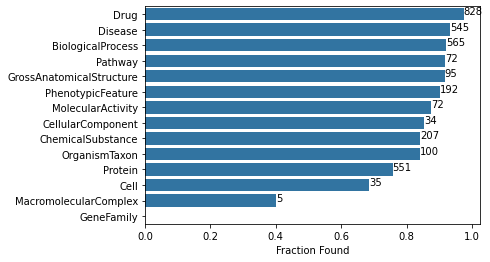

In [18]:
l_c = dmdb_nodes.drop_duplicates(subset=['id'])['label'].value_counts()
f_c = dmdb_nodes.drop_duplicates(subset=['id']).dropna(subset=['bte_id'])['label'].value_counts()


frac = (f_c / l_c).sort_values()

order = frac.index

#label = f_c.loc[order].apply(str) + ' / ' + l_c.loc[order].apply(str)

count_plot_h(frac, annotate=l_c, color=sns.color_palette()[0])#, annotate=label)
plt.xlabel('Fraction Found');

## Edges

In [19]:
dmdb_edges = defaultdict(list)
for p in ind:
    for i, e in enumerate(p['links']):
        for k in ['source', 'key', 'target']:
            # some strings have a unicode Byte order mark
            # let's just strip it for functionality
            dmdb_edges[k].append(e[k].replace('\ufeff', ''))
        dmdb_edges['edge_num'].append(i+1)
        
dmdb_edges = pd.DataFrame(dmdb_edges)

dmdb_edges = (dmdb_edges.sort_values('edge_num')
                        .drop_duplicates(subset=['source', 'key', 'target'], keep='first')
                        .sort_values(['key', 'source', 'target'])
                        .reset_index(drop=True))
dmdb_edges

,source,key,target,edge_num
0,GO:0001508,actively involved in,MESH:D001007,6
1,GO:0001508,actively involved in,MESH:D016584,6
2,GO:0050806,actively involved in,GO:1904058,5
3,MESH:D003065,actively involved in,REACT:R-HSA-392499,3
4,CL:0002559,affected by,MESH:D000505,8
...,...,...,...,...
6345,UniProt:P35367,treats,MESH:D006255,2
6346,UniProt:P35367,treats,MESH:D011537,2
6347,UniProt:P35367,treats,MESH:D012223,2
6348,UniProt:P35367,treats,MESH:D014581,2


In [20]:
dmdb_edges['source_curi'] = dmdb_edges['source'].apply(lambda s: s.split(':')[0])
dmdb_edges['source_curi'] = dmdb_edges['source_curi'].apply(lambda c: dmdb_bte_curi_map.get(c, c))
dmdb_edges['source'] = dmdb_edges['source_curi'] + ':' + dmdb_edges['source'].apply(lambda i: i.split(':')[-1])


dmdb_edges['target_curi'] = dmdb_edges['target'].apply(lambda s: s.split(':')[0])
dmdb_edges['target_curi'] = dmdb_edges['target_curi'].apply(lambda c: dmdb_bte_curi_map.get(c, c))
dmdb_edges['target'] = dmdb_edges['target_curi'] + ':' + dmdb_edges['target'].apply(lambda i: i.split(':')[-1])

dmdb_edges

,source,key,target,edge_num,source_curi,target_curi
0,GO:0001508,actively involved in,MESH:D001007,6,GO,MESH
1,GO:0001508,actively involved in,MESH:D016584,6,GO,MESH
2,GO:0050806,actively involved in,GO:1904058,5,GO,GO
3,MESH:D003065,actively involved in,REACT:R-HSA-392499,3,MESH,REACT
4,CL:0002559,affected by,MESH:D000505,8,CL,MESH
...,...,...,...,...,...,...
6345,UniProtKB:P35367,treats,MESH:D006255,2,UniProtKB,MESH
6346,UniProtKB:P35367,treats,MESH:D011537,2,UniProtKB,MESH
6347,UniProtKB:P35367,treats,MESH:D012223,2,UniProtKB,MESH
6348,UniProtKB:P35367,treats,MESH:D014581,2,UniProtKB,MESH


In [21]:
dmdb_edges['source_bte_id'] = dmdb_edges['source'].map(id_mapper)
dmdb_edges['target_bte_id'] = dmdb_edges['target'].map(id_mapper)

## How many edges are capable of being represented?

In [22]:
len(dmdb_edges.dropna(subset=['source_bte_id', 'target_bte_id']))

5066

In [23]:
len(dmdb_edges)

6350

### Expand the one-to-many ID mappings

In [24]:
edge_info = dt.expand_df_on_col(dmdb_edges, 'source_bte_id')
edge_info = dt.expand_df_on_col(edge_info, 'target_bte_id')

In [25]:
edge_info

,source,key,target,edge_num,source_curi,target_curi,source_bte_id,target_bte_id
0,GO:0001508,actively involved in,MESH:D001007,6,GO,MESH,GO:0001508,UMLS:C0003467
1,GO:0001508,actively involved in,MESH:D016584,6,GO,MESH,GO:0001508,MONDO:0005383
2,GO:0050806,actively involved in,GO:1904058,5,GO,GO,GO:0050806,GO:1904058
3,MESH:D003065,actively involved in,REACT:R-HSA-392499,3,MESH,REACT,MESH:D003065,REACT:R-HSA-392499
4,CL:0002559,affected by,MESH:D000505,8,CL,MESH,CL:0002559,MONDO:0004907
...,...,...,...,...,...,...,...,...
10565,UniProtKB:P35367,treats,MESH:D011537,2,UniProtKB,MESH,NCBIGene:3269,UMLS:C0033774
10566,UniProtKB:P35367,treats,MESH:D012223,2,UniProtKB,MESH,NCBIGene:3269,MONDO:0006004
10567,UniProtKB:P35367,treats,MESH:D014581,2,UniProtKB,MESH,NCBIGene:3269,MONDO:0005492
10568,UniProtKB:P35367,treats,MESH:D014581,2,UniProtKB,MESH,NCBIGene:3269,UMLS:C0042109


## Add metaedge info...

In [26]:
nid_to_label = dmdb_nodes.set_index('id')['label'].to_dict()
edge_info['source_mn'] = edge_info['source'].map(nid_to_label)
edge_info['target_mn'] = edge_info['target'].map(nid_to_label)

In [27]:
edge_info['me'] = edge_info['source_mn'] + ' - ' + edge_info['key'] + ' - ' + edge_info['target_mn']

## Get into tuples...

In [28]:
bte_tups = set([(r.n0, r.n1) for r in bte_result.itertuples()])

In [29]:
for row in edge_info.itertuples():
    f_tup = (row.source_bte_id, row.target_bte_id)
    r_tup = (row.target_bte_id, row.source_bte_id)
    
    edge_info.loc[row.Index, 'fwd_in_bte'] = f_tup in bte_tups
    edge_info.loc[row.Index, 'rev_in_bte'] = r_tup in bte_tups    

In [30]:
edge_info['in_bte'] = edge_info['fwd_in_bte'] | edge_info['rev_in_bte']

## Run comparisons

In [31]:
n_in_bte = edge_info['in_bte'].sum()
n_edges = len(edge_info)

print('{0:} of {1:} bte_edges found ({2:1.2%})'.format(n_in_bte, n_edges, n_in_bte/n_edges))

2808 of 10570 bte_edges found (26.57%)


In [32]:
# Because of 1-many mappings, lets take best case and de-duplicate, with an in_network=True if ONE OR MORE
# of the many mappyings is found.


unique_in_bte = edge_info.sort_values('in_bte', ascending=False).drop_duplicates(subset=['source', 'key', 'target'])

n_in_bte = unique_in_bte['in_bte'].sum()
n_edges = len(unique_in_bte)

print('{0:} of {1:} bte_edges found ({2:1.2%})'.format(n_in_bte, n_edges, n_in_bte/n_edges))

2344 of 6350 bte_edges found (36.91%)


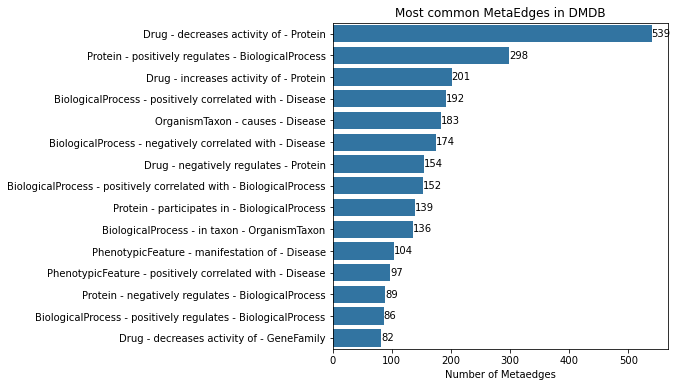

In [33]:
h_num = 15

plt.figure(figsize=(6,6))
count_plot_h(unique_in_bte['me'].value_counts().head(h_num), color=sns.color_palette()[0])

plt.title('Most common MetaEdges in DMDB')
plt.xlabel('Number of Metaedges');

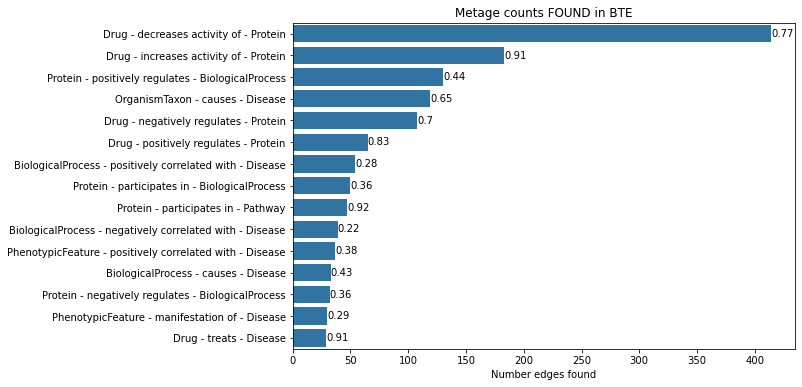

In [34]:
plt.figure(figsize=(9,6))

found = unique_in_bte.query('in_bte')['me'].value_counts()
total = unique_in_bte['me'].value_counts()
found_pct = found / total

count_plot_h(found.head(h_num), found_pct.loc[found.head(h_num).index], color=sns.color_palette()[0])
plt.title('Metage counts FOUND in BTE')
plt.xlabel('Number edges found');

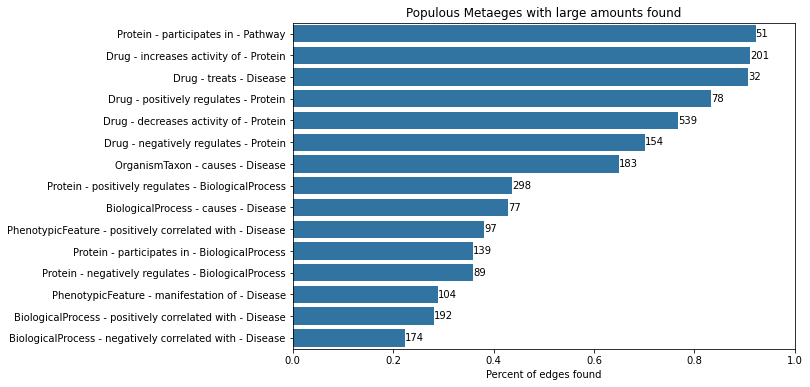

In [35]:
plt.figure(figsize=(9,6))

order = found_pct * total
order = order.sort_values(ascending = False)

count_plot_h(found_pct.loc[order.head(h_num).index], 
             total.loc[order.head(h_num).index], 
             order = sorted(order.head(h_num).index.tolist(), key=lambda o: (1-found_pct.loc[o], order.loc[o]), reverse=False),
             color=sns.color_palette()[0])
plt.xlim([0, 1])
plt.title('Populous Metaeges with large amounts found')
plt.xlabel('Percent of edges found');

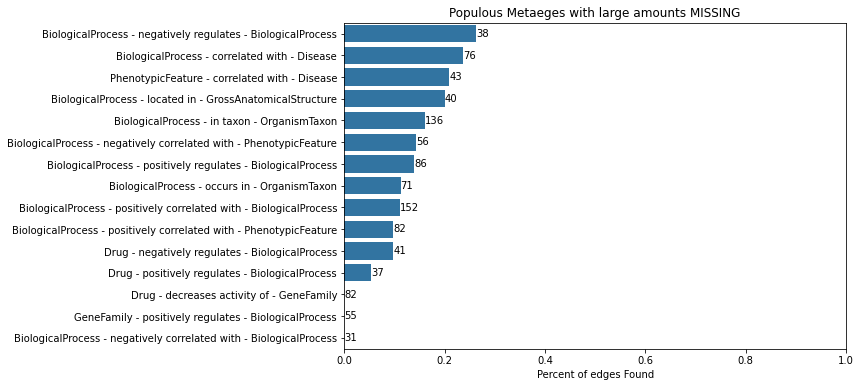

In [36]:
plt.figure(figsize=(9,6))

previously_used = order.head(h_num).index.tolist()

missing = unique_in_bte.query('not in_bte and me not in @previously_used')['me'].value_counts()
missing_pct = missing / total

new_order = missing_pct * total
new_order = new_order.sort_values(ascending=False)

count_plot_h(1-missing_pct.loc[new_order.head(h_num).index], 
             total.loc[new_order.head(h_num).index], 
             order = sorted(new_order.head(h_num).index.tolist(), key=lambda o: (1-missing_pct.loc[o], new_order.loc[o]), reverse=True),
             color=sns.color_palette()[0])
plt.xlim([0, 1])
plt.title('Populous Metaeges with large amounts MISSING')
plt.xlabel('Percent of edges Found');